# Country results for Heatwaves

Calculate N exposures for each country

Optional: calculate exposure weighted heatwave length

1.2 Heatwaves

- Australia
- Brazil
- Canada
- EU28
- France
- Germany
- India
- Spain
- Sweden
- UK/GB
- USA (Hawaii? Alaska? -> check with country author)



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook, tqdm

import population_tools

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [3]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.2 heatwaves')

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

# NOTE that we are now using 0.5 degree data (older versions used 0.75)
MIN_TEMPERATURES_FOLDER = WEATHER_SRC / 'era_interim_0.5deg' / 'summer_min_temperature'
CLIMATOLOGY_DAILY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'climatology_daily_tmin_quantiles.nc'

# WISHLIST - instead of re-calculating the whole thing each year, would like to just add the newest year.
# For this would need to stablise the method though - discuss with Nick et al.
# I'm not sure it's possible to 'fully' automate since e.g. the demographic data might need to change, GWPv4 is only until 2020
# TODO: indicator -> results for year or result year -> indicator?
INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2019'


# TODO - should not need these anymore with the new gridded demographics
UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'


COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

# LIMIT to the following countries for now
# TODO move to 3-letter codes 
# SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL']
# SELECTED_COUNTRIES.sort()

## Load country data

In [4]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [5]:
COUNTRIES_LOOKUP.head()

GRIDCODE ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0         4     AFG         4     Afghanistan           4   
1         8     ALB         8         Albania           8   
2        12     DZA        12         Algeria          12   
3        16     ASM        16  American Samoa          16   
4        20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  GRSTART  \
0  Population estimate/projection         6      2011          2     1998   
1                    Final census         1      2011          3     2001   
2                    Final census         1      2008          2     1998   
3                    Final census         1      2010          3     2000   
4             Population register         5      2010          1     2000   

   GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0   2011        1        1979   4507.466751  
1   2011        3        2011    115.949835  
2   2008        2        2008  50884.794880  
3   2010        3        2010      7.612468  
4   2010        1        2011     79.902822

## Load age percentage rasters

In [6]:
demographics = xr.open_dataarray(DEMOGRAPHICS_FILE)
fraction_over_65 = demographics.sel(age_band_lower_bound=65, drop=True).load()
population = xr.open_dataarray(POPULATION_FILE)
population_over_65 = population * fraction_over_65

## Heatwave change

### Load data


In [7]:
heatwaves_lengths_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_lengths_delta.nc')
heatwaves_counts_delta = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER /'heatwaves_counts_delta.nc')
heatwaves_pop_events = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [8]:
heatwaves_lengths_reference_ts = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposure.xlsx', 
                                     sheet_name='heatwaves_lengths')

In [9]:
heatwaves_pop_events_reference_ts = heatwaves_pop_events.sum(dim=['latitude', 'longitude']).compute()

# N Exposures by country


For Heatwaves, want the same plots as were in the original paper

- the heatwave exposure total number change (not normalised)
- the heatwave length change


In [10]:
exposure_results = []
# for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code

    country_exposures_ts = (heatwaves_pop_events * country_mask).sum(dim=['latitude', 'longitude'])

    exposure_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

exposure_results = pd.concat(exposure_results, axis=1)

In [15]:
# Save excel 
with pd.ExcelWriter(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.xlsx', mode='a') as writer:
    exposure_results.to_excel(writer, sheet_name='countries_heatwave_exposures')

In [11]:
exposure_results = pd.read_excel(RESULTS_FOLDER / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.xlsx',
                                  sheet_name='countries_heatwave_exposures')

# Add EU

In [17]:
EU_RASTER =  xr.open_dataset(POP_DATA_SRC / 'countries_eu28_30min_era_compat.nc')

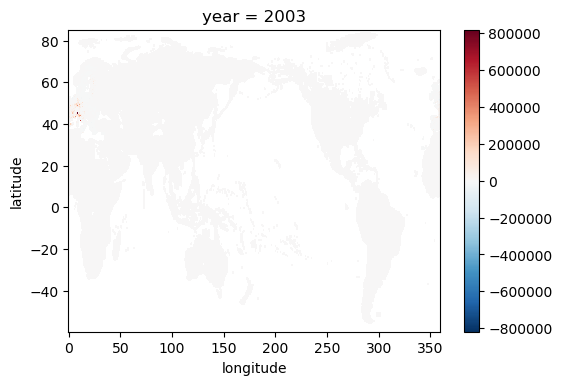

In [18]:
(heatwaves_pop_events * EU_RASTER.country_codes).sel(year=2003).plot()


In [19]:
eu_exposures_ts = (heatwaves_pop_events * EU_RASTER.country_codes).sum(dim=['latitude', 'longitude'])

In [20]:
eu_exposures_ts = eu_exposures_ts.to_dataframe('exposure_events')

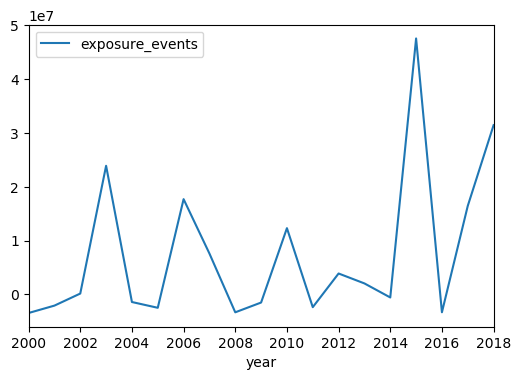

In [21]:
eu_exposures_ts.plot()

In [22]:
# Save excel 
with pd.ExcelWriter(RESULTS_FOLDER / 'heatwaves_n_exposure_change_2000-2018.xlsx', mode='a') as writer:
    eu_exposures_ts.to_excel(writer, sheet_name='eu_heatwave_exposures')

# Save the gridded (country detailed) data as a text file for the visualisation people

NOTE: since it's gridded, don't actully need to add country masks (maybe they want them later i don't know...)

In [22]:
EXPOSURES_EXCEL_FOLDER = RESULTS_FOLDER / 'exposure_maps_as_tables'
EXPOSURES_EXCEL_FOLDER.mkdir(exist_ok=True)

In [36]:
for year in range(2000, MAX_YEAR+1):
    heatwave_exposures_long = heatwaves_pop_events.sel(year=year).to_dataframe('heatwave_exposure_change').dropna().reset_index()
    heatwave_exposures_long.to_csv(EXPOSURES_EXCEL_FOLDER/ f'{year}_heatwave_exposure_change.csv', index=False)

# TODO clean up below

# Filter tiny countries

Filter countries with area less than the resolution of the weather grid,  i.e. where country area in 'square degrees' is less than 0.5*0.5 = 0.25 square degrees

In [66]:
tiny_states = set(COUNTRIES[COUNTRIES.geometry.area < 0.25].iso_a2) & set(exposure_results.columns)
tiny_state_ids = COUNTRIES[COUNTRIES.iso_a2.isin(tiny_states)][['iso_a2', 'name']]
tiny_state_ids.to_excel(RESULTS_FOLDER / 'small_area_states_ids.xlsx', index=False)

In [46]:
ax = exposure_results.plot(color='C0',alpha=0.1, legend=False)
global_exposure_reference['heatwave_exposure_events'].plot(color='C1', ax=ax)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [13]:
EXPOSURES_PLOTS = RESULTS_FOLDER / 'exposures_plots'
EXPOSURES_PLOTS.mkdir(exist_ok=True)

In [21]:
# for h in exposure_results:
    
#     country_name = COUNTRIES_NAMES[h] 
    
#     f, ax = plt.subplots()
#     (exposure_results[h] / 1e6).plot(color='C0', ax=ax,legend=False, 
#                                         label=f'{country_name} exposures')

#     ax.set_xlabel('Year')
#     ax.set_ylabel('''Heatwaves exposures change \n(millions)''')
#     ax.set_title(f'{country_name}')
#     plt.xticks(exposure_results.index[0::2])

    
#     f.savefig(EXPOSURES_PLOTS / f'{h}_heatwaves_exposure_change_2000-{MAX_YEAR}.png', 
#               dpi=300, bbox_inches='tight')

## Heatwave length exposure weighted change

Need to re-calculate so that we normalise by the country population

In [15]:
COUNTRY_RASTER_CLIM_FILES = DATA_SRC/ 'lancet/countries_climate_rasters/*.nc'
COUNTRIES_RASTER_CLIM = xr.open_mfdataset(str(COUNTRY_RASTER_CLIM_FILES))

In [16]:
length_ref_results = []
for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
    country_mask = COUNTRIES_RASTER_CLIM.sel(iso_a2=iso_a2).country_mask.load().drop('iso_a2')
    country_lengths_ts = (heatwaves_lengths_delta * country_mask.where(country_mask > 0)).mean(dim=['latitude', 'longitude'])
    
    length_ref_results.append(country_lengths_ts.to_dataframe(iso_a2))
    
length_ref_results = pd.concat(length_ref_results,axis=1)

In [17]:
length_results = []
for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
    country_mask = COUNTRIES_RASTER.sel(iso_a2=iso_a2).country_mask.load().drop('iso_a2')
    country_exposures_ts = population_tools.project_to_population(heatwaves_lengths_delta,
                                                                  weights=country_mask.where(country_mask > 0) * pct_age_rasters,
                                                                  norm=True, 
                                                                  end_year=MAX_YEAR)
    
    length_results.append(country_exposures_ts.to_dataframe(iso_a2))
    
length_results = pd.concat(length_results,axis=1)

In [18]:
with pd.ExcelWriter(RESULTS_FOLDER / 'heatwave_length_exposure_weighted.xlsx') as writer:
    length_results.to_excel(writer, sheet_name='weighted heatwave length change')    
    global_reference.to_excel(writer, sheet_name='global reference')


In [19]:
LENGTHS_PLOTS = RESULTS_FOLDER / 'lengths_plots'
LENGTHS_PLOTS.mkdir(exist_ok=True)

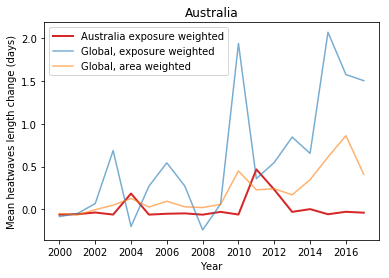

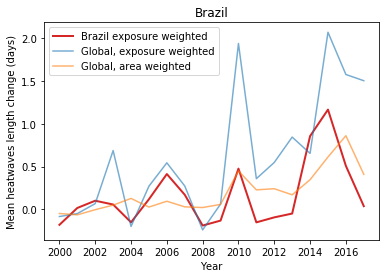

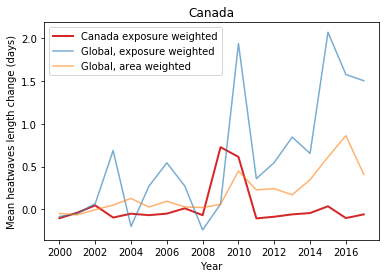

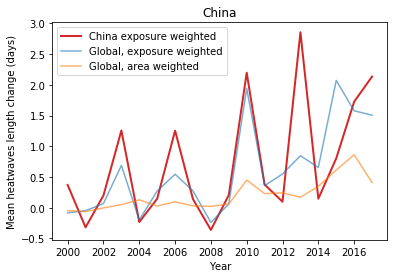

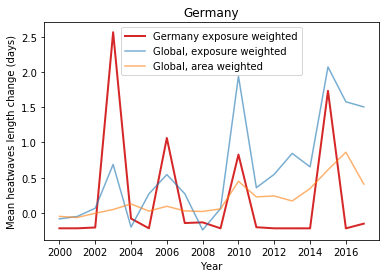

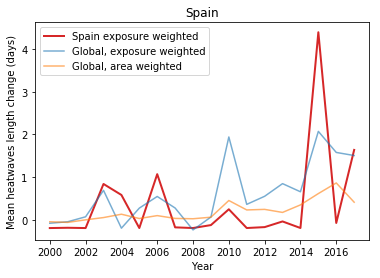

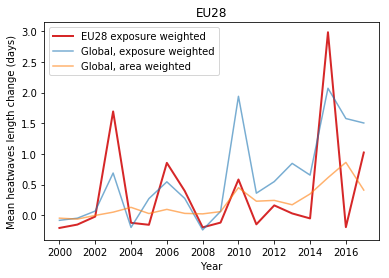

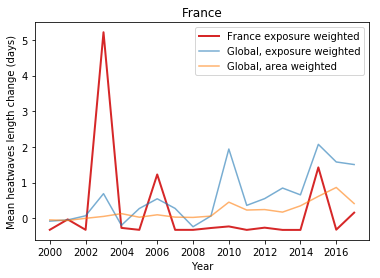

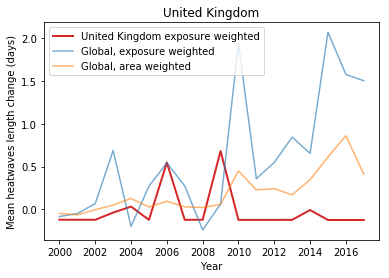

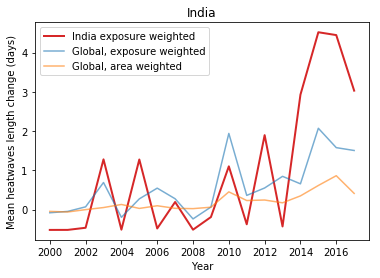

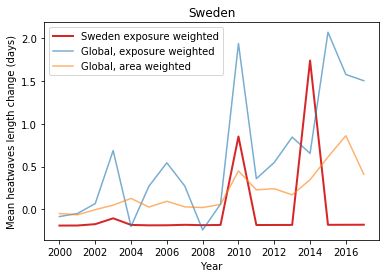

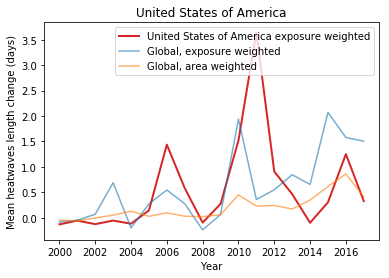

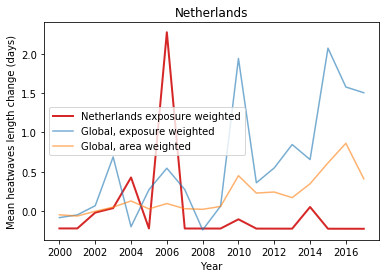

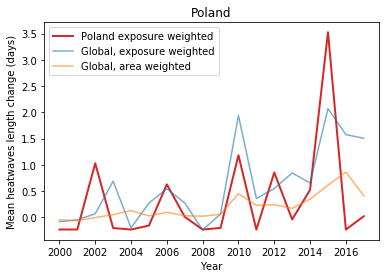

In [20]:
for h in length_results:
    
    country_name = COUNTRIES_NAMES[h]
    
    f, ax = plt.subplots()
    length_results[h].plot(color='C3', 
                           linewidth=2,
                           ax=ax,legend=False,
                           label=f'{country_name} exposure weighted')
#     length_ref_results[h].plot(color='C1',label=f'{country_name} area weighted', ax=ax)
    heatwaves_l_pop_ts.plot(color='C0',
                            alpha=0.6,
                            label='Global, exposure weighted', 
                            ax=ax)
    heatwaves_lengths_ts.plot(color='C1',
                              alpha=0.6,
                              label='Global, area weighted',
                              ax=ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('''Mean heatwaves length change (days)''')
    ax.set_title(f'{country_name}')
    plt.legend()
    plt.xticks(length_results.index[0::2])
    
    f.savefig(LENGTHS_PLOTS / f'{h}_heatwaves_mean_length_exposure_2000-{MAX_YEAR}.png', 
              dpi=300, bbox_inches='tight')





## Map plots

- Need to find a 2d representation that gives a reasonable impression of the trend, with particular focus on the spatial distribution of the trend
- Especially for heatwaves which are rather random, taking the change for a single year is rather arbitrary. Instead we need to apply a reduction operation to get a 2D array from the time series
- I think doing a simple average of the total heatwave exposure change relative to the historical average should work. This gives for each pixel the average change (increase) in heat wave exposure.


In [41]:
heatwaves_counts_delta_mean = heatwaves_counts_delta.mean(dim='year')
heatwaves_counts_delta_mean.name = 'mean_change_n_heatwaves'

In [42]:
heatwaves_exposure_delta_mean = heatwaves_exposure_delta.mean(dim='year')

In [45]:
borders = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m')

In [46]:
def plot_country(country_iso):
    if country_iso in eu_clip.adm0_a3.values:
        print(country_iso)
        tmp = eu_clip.set_index('adm0_a3')
    else:
        tmp = countries.set_index('adm0_a3')
    
    country_name = tmp.loc[country_iso]['name']
#     bounds = countries[countries.iso_a2 == country_iso].geometry.bounds.iloc[0]

    minx, miny, maxx, maxy = tmp.loc[country_iso].geometry.bounds


    bounds = (minx, maxx, miny, maxy)

    f = plt.figure(figsize=(6,3))

    ax = plt.axes(projection=ccrs.PlateCarree())
    heatwaves_exposure_delta_mean.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                                                  robust=True,
                              cbar_kwargs=dict(label='Change in exposures'),
                              cmap='RdBu_r'
                             )
    ax.coastlines()

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    ax.set_extent(bounds)
    plt.tight_layout()
    plt.title(f'''{country_name} mean change in heatwave exposures per year
      in 2000-2016 period relative to historical average''')
    
    return f, ax
    # f.savefig('heatwaves_delta.png', dpi=300, bbox_inches='tight')




GBR
FRA
SWE


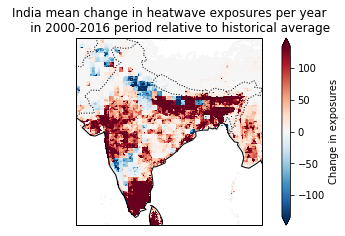

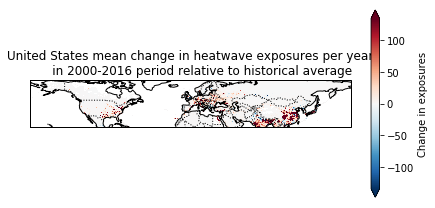

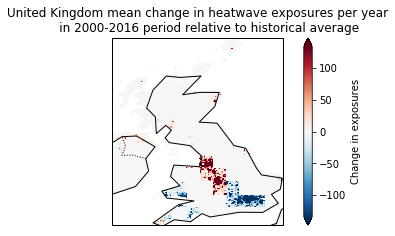

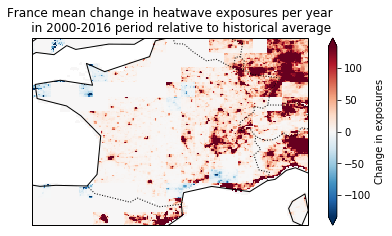

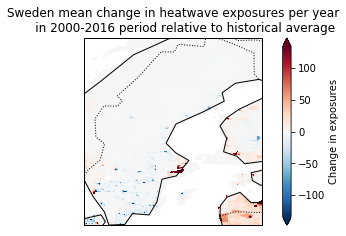

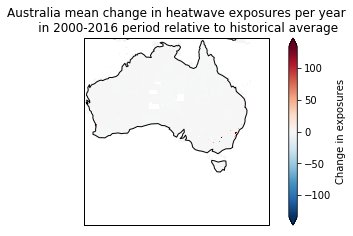

In [47]:
# TODO adjust bounds esp for france
for country_iso in select_country_a3:
    f, ax = plot_country(country_iso)
    f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


### Do USA

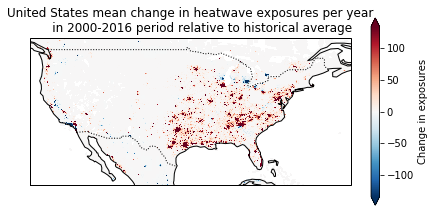

In [48]:
country_iso = 'USA'
f, ax = plot_country(country_iso)

ax.set_extent((-126.5, -62.5, 22, 47))
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


# -170.2,17.7,-50.6,74.1

### Do Australia

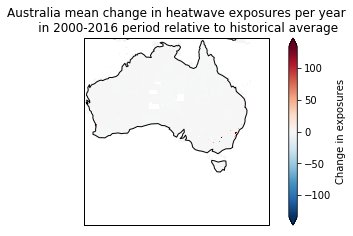

In [49]:
country_iso = 'AUS'
f, ax = plot_country(country_iso)
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')




In [15]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo, norm=False) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_total_expo_by_country = pd.concat(results, axis=1)

In [18]:
aus_hw_total_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_total_exposure.csv')

In [13]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_length_expo_by_country = pd.concat(results, axis=1)

In [19]:
aus_hw_length_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_heatwave_mean_length_exposure.csv')